# GNN + Human Feedback (REINFORCE 방식) 추천 시스템 개발

# 1. 라이브러리 임포트

In [59]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv

# 2. YosemiteRecommender GNN 모델 정의

In [60]:
class YosemiteRecommender(nn.Module):
    def __init__(self, metadata, hidden_dim=64):
        super().__init__()
        self.metadata = metadata

        self.conv1 = SAGEConv((-1, -1), hidden_dim)
        self.conv2 = SAGEConv((hidden_dim, hidden_dim), hidden_dim)
        self.conv3 = SAGEConv((hidden_dim, hidden_dim), hidden_dim)
        self.dropout = nn.Dropout(0.3)

        # Expert 네트워크 2개 (위치 기반 / 취향 기반)
        self.expert_location = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )

        self.expert_preference = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )

        # 게이트: 두 expert를 어떻게 섞을지 결정
        self.gate = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x_dict, edge_index_dict):
        x = x_dict['visit_area']
        edge_index = edge_index_dict[('visit_area', 'move_1', 'visit_area')]

        h = F.relu(self.conv1(x, edge_index))
        h = self.dropout(h)
        h = F.relu(self.conv2(h, edge_index))
        h = self.dropout(h)
        h = self.conv3(h, edge_index)

        loc_score = self.expert_location(h).squeeze(-1)
        pref_score = self.expert_preference(h).squeeze(-1)
        gate_weight = torch.softmax(self.gate(h), dim=-1)  # [N, 2]

        final_score = gate_weight[:, 0] * loc_score + gate_weight[:, 1] * pref_score
        return final_score  # [N]

# 3. 데이터 구성

In [61]:
data_path = "../data/"

def load_tensor(name):
    return torch.tensor(np.load(os.path.join(data_path, name)), dtype=torch.float if 'features' in name else torch.long)

user_x = load_tensor("user_features.npy")
travel_x = load_tensor("travel_features.npy")
visit_x = load_tensor("visit_features.npy")
edge_user_travel = load_tensor("edge_user_to_travel.npy")
edge_travel_visit = load_tensor("edge_travel_to_visit.npy")

## 3-1. HeteroData 구성

In [62]:
hetero_data = HeteroData()
hetero_data['user'].x = user_x
hetero_data['travel'].x = travel_x
hetero_data['visit_area'].x = visit_x
hetero_data[('user', 'traveled', 'travel')].edge_index = edge_user_travel
hetero_data[('travel', 'contains', 'visit_area')].edge_index = edge_travel_visit

In [63]:
for fname in os.listdir(data_path):
    if fname.startswith("edge_visit_move_") and fname.endswith(".npy"):
        move_type = fname.replace("edge_visit_move_", "").replace(".npy", "")
        edge_index = load_tensor(fname)
        hetero_data[('visit_area', f'move_{move_type}', 'visit_area')].edge_index = edge_index

metadata = hetero_data.metadata()
metadata

(['user', 'travel', 'visit_area'],
 [('user', 'traveled', 'travel'),
  ('travel', 'contains', 'visit_area'),
  ('visit_area', 'move_1', 'visit_area'),
  ('visit_area', 'move_2', 'visit_area'),
  ('visit_area', 'move_3', 'visit_area'),
  ('visit_area', 'move_6', 'visit_area'),
  ('visit_area', 'move_4', 'visit_area'),
  ('visit_area', 'move_5', 'visit_area')])

# 4. 모델, 옵티마이저 초기화

In [64]:
model = YosemiteRecommender(metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. GNN 출력 → softmax 확률 변환 → 샘플링

In [65]:
temperature = 2.0
model.eval()
with torch.no_grad():
    logits_before = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_before = F.softmax(logits_before / temperature, dim=0)
    top_before = torch.topk(probs_before, k=5)
    print("[학습 전 추천 Top-5 index]:", top_before.indices.tolist())

[학습 전 추천 Top-5 index]: [220, 692, 773, 101, 1499]


## 5-1. Negative Feedback

In [66]:
feedback_indices = top_before.indices.tolist()[2:3]  # 유저가 싫어한 추천 장소 인덱스
reward = -1.0  # 부정적 피드백

print("싫다고 한 것 : ", feedback_indices)

싫다고 한 것 :  [773]


In [67]:
for idx in feedback_indices:
    for step in range(10):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward
        loss.backward()
        optimizer.step()

In [68]:
model.eval()
with torch.no_grad():
    logits_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_after = F.softmax(logits_after / temperature, dim=0)
    top_after = torch.topk(probs_after, k=5)
    print("[학습 후 추천 Top-5 index]:", top_after.indices.tolist())

[학습 후 추천 Top-5 index]: [15497, 5270, 11662, 1526, 3606]


## 5-2. Positive Feedback

In [ ]:
positive_feedback = top_before.indices.tolist()[2:3]
reward_pos = 1.0
print("좋다고 한 것 : ", positive_feedback)

In [70]:
for idx in positive_feedback:
    for step in range(10):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward_pos
        loss.backward()
        optimizer.step()

In [71]:
model.eval()
with torch.no_grad():
    logits_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_after = F.softmax(logits_after / temperature, dim=0)
    top_after = torch.topk(probs_after, k=5)
    print("[학습 후 추천 Top-5 index]:", top_after.indices.tolist())

[학습 후 추천 Top-5 index]: [12537, 10816, 5270, 10900, 10373]


# 6. REINFORCE 손실 계산 후 파라미터 업데이트

In [72]:
with torch.no_grad():
    x = hetero_data.x_dict['visit_area']
    edge_index = hetero_data.edge_index_dict[('visit_area', 'move_1', 'visit_area')]
    h = F.relu(model.conv1(x, edge_index))
    h = model.conv2(h, edge_index)

    loc_score = model.expert_location(h).squeeze(-1)
    pref_score = model.expert_preference(h).squeeze(-1)
    print("[Top-5 위치 기반 추천 index]:", torch.topk(loc_score, k=5).indices.tolist())
    print("[Top-5 취향 기반 추천 index]:", torch.topk(pref_score, k=5).indices.tolist())


[Top-5 위치 기반 추천 index]: [391, 1226, 579, 116, 650]
[Top-5 취향 기반 추천 index]: [578, 1042, 292, 4, 240]


# 7.추천 확률 분포 시각화

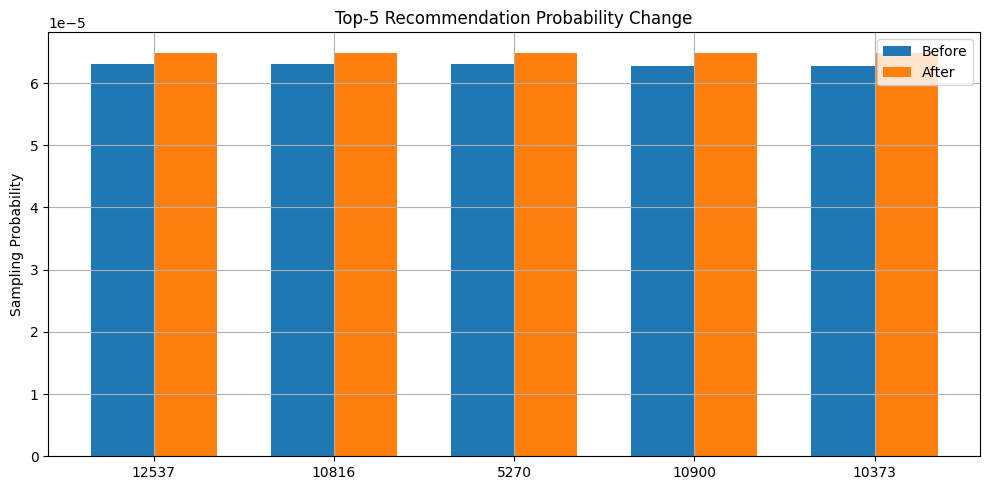

In [73]:
import matplotlib.pyplot as plt

indices = top_after.indices.tolist()
labels = [f"{i}" for i in indices]
before_vals = [probs_before[i].item() for i in indices]
after_vals = [probs_after[i].item() for i in indices]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, before_vals, width, label='Before')
ax.bar(x + width/2, after_vals, width, label='After')

ax.set_ylabel('Sampling Probability')  # Y축: 샘플링 확률
ax.set_title('Top-5 Recommendation Probability Change')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()  # 범례 표시
plt.grid(True)
plt.tight_layout()
plt.show()